## Setup

In [6]:
from pathlib import Path
import os

# Define paths based on environment
if Path("/kaggle").exists():
    os.environ["AMBIENTE"] = "KAGGLE"
    os.environ["TENSORBOARD_NO_TF"] = "1"

    PATH_DATASET = Path("/kaggle/working/STROKE_PREDICTION")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET
elif Path("/content").exists():
    os.environ["AMBIENTE"] = "COLAB"
    PATH_DATASET = Path("/content/DELETAR")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"
else:
    os.environ["AMBIENTE"] = "LOCAL"
    PATH_CODE = Path.cwd()
    PATH_DATASET = PATH_CODE.parent
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"


# Check if installation has been done
INSTALL_MARKER = PATH_DATASET / ".install_complete"
try:
    if not INSTALL_MARKER.exists():
        # Install uv
        pass
        !pip install uv

        # Environment-specific setup
        if os.environ["AMBIENTE"] == "KAGGLE":
            import kaggle_secrets

            user_secrets = kaggle_secrets.UserSecretsClient()
            github_pat = user_secrets.get_secret("GITHUB_PAT")

            os.chdir("/kaggle/working")
            os.system(
                f"git clone https://{github_pat}@github.com/lfaoliveira/STROKE_PREDICTION.git"
            )
            os.chdir(PATH_DATASET)

        elif os.environ["AMBIENTE"] == "LOCAL":
            os.system("git pull origin main")

        # Install dependencies
        os.chdir(PATH_DATASET)
        os.system("uv pip install --requirements pyproject.toml --system")

        if os.environ["AMBIENTE"] == "KAGGLE":
            os.system(
                "uv pip install --upgrade --force-reinstall --no-cache-dir scipy numpy matplotlib protobuf tensorboard"
            )

        # Mark installation as complete
        INSTALL_MARKER.touch()
        print("Installation completed")
    else:
        print("Installation already completed, skipping...")

    os.chdir(PATH_CODE)
    print(f"Current working directory: {os.getcwd()}")
except Exception:
    print("FALHA AO INICIAR NOTEBOOK")

Installation already completed, skipping...
Current working directory: c:\Users\Eu\Desktop\PROJETO_PESS_DADOS\src


## Exploratory Data Analysis

In [ ]:
from DataProcesser.dataset import StrokeDataset
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Load data
# =========================
df = StrokeDataset().original_df.copy()

# =========================
# 1. Dataset overview
# =========================
print("Shape:", df.shape)
print(df.info())
print("\nMissing values:\n", df.isna().sum())

# =========================
# 2. Target distribution
# =========================
stroke_dist = df["stroke"].value_counts(normalize=True) * 100
print("\nStroke distribution (%):\n", stroke_dist)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# =========================
# 1. Stroke distribution
# =========================
df["stroke"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Stroke Distribution (Imbalanced)")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["No Stroke", "Stroke"], rotation=0)
axes[0].set_ylabel("Count")
axes[0].set_yticks([i for i in range(0, 4501, 500)])
# =========================
# 2. Age vs Stroke
# =========================
df.boxplot(column="age", by="stroke", ax=axes[1])
axes[1].set_title("Age by Stroke")
axes[1].set_xlabel("Stroke")
axes[1].set_ylabel("Age")

# =========================
# 3. Glucose vs Stroke
# =========================
df.boxplot(column="avg_glucose_level", by="stroke", ax=axes[2])
axes[2].set_title("Avg Glucose by Stroke")
axes[2].set_xlabel("Stroke")
axes[2].set_ylabel("Glucose Level")

# =========================
# 4. BMI vs Stroke
# =========================
df.boxplot(column="bmi", by="stroke", ax=axes[3])
axes[3].set_title("BMI by Stroke")
axes[3].set_xlabel("Stroke")
axes[3].set_ylabel("BMI")

# =========================
# 5. Hypertension
# =========================
pd.crosstab(df["hypertension"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[4], rot=0
)
axes[4].set_title("Stroke Rate by Hypertension")
axes[4].set_ylabel("Percentage (%)")
axes[4].legend(["No Stroke", "Stroke"])

# =========================
# 6. Heart disease
# =========================
pd.crosstab(df["heart_disease"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[5], rot=0
)
axes[5].set_title("Stroke Rate by Heart Disease")
axes[5].set_ylabel("Percentage (%)")
axes[5].legend(["No Stroke", "Stroke"])

# =========================
# 7. Smoking status
# =========================
pd.crosstab(df["smoking_status"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="barh", ax=axes[6])
axes[6].set_title("Stroke Rate by Smoking Status")
axes[6].set_xlabel("Percentage (%)")
axes[6].legend(["No Stroke", "Stroke"])

# =========================
# 8. Work type
# =========================
pd.crosstab(df["work_type"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="bar", ax=axes[7], rot=30)
axes[7].set_title("Stroke Rate by Work Type")
axes[7].set_ylabel("Percentage (%)")
axes[7].legend(["No Stroke", "Stroke"])

# =========================
# 9. Empty / summary slot
# =========================
axes[8].axis("off")
axes[8].set_title("EDA Summary Slot")

plt.suptitle("Stroke Dataset – Exploratory Data Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Normal training

In [ ]:
from pathlib import Path
import os
from typing import Literal
import logging

import gc
import mlflow
import torch
from Models.mlp import MLP, MLPSearchSpace
from Models.kan import MyKan, KANSearchSpace
from lightning import seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
from mlflow.pytorch import autolog
from lightning.pytorch.callbacks import EarlyStopping
from DataProcesser.datamodule import StrokeDataModule
import pandas as pd


def zip_res(
    path_sqlite: str, path_mlflow: Path, filename: str, dest_folder: Path | None = None
):
    import shutil

    path_sqlite_clean = path_sqlite.replace("sqlite:///", "")
    print(f"CWD: {Path.cwd()}\n")
    PATH_TEMP = Path.cwd() / "ZIP_TEMP"
    shutil.rmtree(PATH_TEMP, ignore_errors=True)
    PATH_TEMP.mkdir(parents=True, exist_ok=True)

    shutil.copy(path_sqlite_clean, PATH_TEMP / Path(path_sqlite_clean).name)
    shutil.copytree(path_mlflow, PATH_TEMP / path_mlflow.name)

    # Determine destination folder
    if dest_folder is None:
        dest_folder = Path.cwd()
    else:
        dest_folder.mkdir(parents=True, exist_ok=True)

    # Create zip file in destination folder
    zip_path = dest_folder / filename.replace(".zip", "")
    shutil.make_archive(str(zip_path), "zip", PATH_TEMP)
    shutil.rmtree(PATH_TEMP)
    print(f"PATH ZIPFILE: {zip_path.with_suffix('.zip').resolve()}")


def supress_warnings():
    # Suppress specific MLflow warnings
    logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)
    logging.getLogger("mlflow").setLevel(logging.ERROR)

    # Suppress PyTorch Lightning info messages
    logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)
    


def model_choice(CHOICE, INPUT_DIMS, N_CLASSES):
    recall_factor = 4.0
    if CHOICE == "MLP":
        search_space = MLPSearchSpace()

        keys = search_space.Keys
        hyperparams = {
            keys.BATCH_SIZE: 32,
            keys.HIDDEN_DIMS: 512,
            keys.LR: 1e-3,
            keys.WEIGHT_DECAY: 1e-5,
            keys.BETA0: 0.900,
            keys.BETA1: 0.99,
            keys.N_LAYERS: 64,
        }
        suggested_hparams = search_space.suggest(hyperparams)
        model = MLP(
            INPUT_DIMS,
            N_CLASSES,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
    elif CHOICE == "KAN":
        search_space = KANSearchSpace()
        keys = search_space.Keys
        hyperparams = {
            keys.BATCH_SIZE: 32,
            keys.HIDDEN_DIMS: 32,
            keys.LR: 1e-3,
            keys.WEIGHT_DECAY: 1e-5,
            keys.BETA0: 0.900,
            keys.BETA1: 0.99,
            keys.GRID: 54,
            keys.SPLINE_POL_ORDER: 3,
        }
        suggested_hparams = search_space.suggest(hyperparams)
        model = MyKan(
            INPUT_DIMS,
            N_CLASSES,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
    else:
        raise ValueError("ESCOLHA DE MODELO ERRADA!")
    return model, suggested_hparams, keys




## -----------------------------COLAR NO KAGGLE------------------
def main(CHOICE: str):
    ###------SEEDS---------###
    RAND_SEED = 42
    seed_everything(RAND_SEED)
    supress_warnings()

    AMBIENTE = os.environ["AMBIENTE"]
    GPU = True if AMBIENTE in ["KAGGLE", "COLAB"] else False
    ## ----------VARIAVEIS TREINO-----------
    cpus = os.cpu_count()
    WORKERS = cpus if cpus is not None else 1
    NUM_DEVICES = 2 if GPU else 1
    NUM_NODES = 1
    BATCH_SIZE = 32
    EPOCHS = 2
    PATIENCE = 20
    ARTIFACT_PATH = PATH_OUTPUT_DIR / "artifacts"
    os.makedirs(ARTIFACT_PATH, exist_ok=True)

    #### -------- VARIAVEIS DE LOGGING ------------
    EXP_NAME = f"stroke_{CHOICE}_1"
    RUN_NAME: str | None = f"normal_{CHOICE}"
    MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    ## ----------VARIAVEIS MODELO-----------
    N_CLASSES = 2

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)
    datamodule.prepare_data()
    datamodule.setup("fit")

    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0
    model, hparams, keys = model_choice(CHOICE, INPUT_DIMS, N_CLASSES)

    _ = model(model.example_input_array)

    # loop principal de treinamento
    with mlflow.start_run(run_name=RUN_NAME) as run:
        active_run_id = run.info.run_id

        mlflow_logger = MLFlowLogger(
            experiment_name=EXP_NAME,
            tracking_uri=MLF_TRACK_URI,
            log_model=True,
            run_id=active_run_id,
        )

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=PATIENCE, mode="min"
        )

        trainer = Trainer(
            max_epochs=EPOCHS,
            devices=NUM_DEVICES,
            accelerator="gpu" if GPU else "cpu",
            num_nodes=NUM_NODES,
            logger=mlflow_logger,
            enable_checkpointing=False,
            callbacks=[early_stopping],
        )
        trainer.fit(model, datamodule=datamodule)
        mlflow.log_params(dict(model.hparams))

        # Test and log artifacts (useful for the Analysis section)
        test_df = datamodule.dataset.original_df.copy()
        test_df["pred"] = None
        test_df["error"] = None

        # Perform one-pass test logic on the full test dataset
        _, test_dataset = datamodule.test_dataloader()
        return_dict = model.test_step(
            test_dataset=test_dataset,
            output_df=test_df,
        )
        test_df = return_dict["output_df"]

        # Log test metrics to MLFlow
        test_results = model.test_metrics.compute()
        mlflow.log_metrics(
            {f"test_{k}": float(v) for k, v in test_results.items() if v.numel() == 1}
        )
        model.test_metrics.reset()

        name = f"test_results_{run.info.run_id}.csv"
        path_test_csv = Path(ARTIFACT_PATH, name)
        test_df.to_csv(path_test_csv)
        mlflow.log_artifact(str(path_test_csv))

        torch.cuda.empty_cache()

    return


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        for choice in models:
            # trains model based on architecture
            main(choice)

        NAME_RESZIP = "resultado_kaggle_stroke_normal"
        MLRUNS_FOLDER = Path.cwd() / "mlruns"
        MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"
        ZIP_ROOT = (
            PATH_DATASET / ".." if os.environ["AMBIENTE"] == "KAGGLE" else PATH_DATASET
        )
        zip_res(MLF_TRACK_URI, MLRUNS_FOLDER, NAME_RESZIP, ZIP_ROOT)
        print("\n", "=" * 60)
        print(f"RESULTADOS ZIPADOS {Path(ZIP_ROOT, NAME_RESZIP).resolve()}")
        print("=" * 60, "\n")

    except Exception as e:
        raise e
    gc.collect()

    if os.environ["AMBIENTE"] == "LOCAL":
        from view.dashboard import see_model

        see_model(PATH_DATASET / "mlflow.db", PATH_DATASET / ".." / "mlruns")


Seed set to 42




DATASET:
          age  hypertension  heart_disease  avg_glucose_level       bmi  \
id                                                                        
77  -1.324241     -0.318067      -0.228208          -0.438884 -1.310695   
84   0.538054     -0.318067      -0.228208          -0.363242  0.331934   
91  -0.038371     -0.318067      -0.228208          -0.152525 -1.323428   
99  -0.526115     -0.318067      -0.228208           0.080704  2.980513   
129 -0.836497     -0.318067      -0.228208          -0.174588 -0.342945   

     gender_code  ever_married_code  work_type_code  Residence_type_code  \
id                                                                         
77     -0.833023          -1.370831        1.674998            -1.014569   
84      1.198428           0.729484       -0.155697             0.985640   
91     -0.833023          -1.370831       -0.155697             0.985640   
99     -0.833023          -1.370831       -0.155697             0.985640   
129    


  | Name         | Type             | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------------------
0 | model        | Sequential       | 16.8 M | train | [10]     | [2]      
1 | val_metrics  | MetricCollection | 0      | train | ?        | ?        
2 | test_metrics | MetricCollection | 0      | train | ?        | ?        
---------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.267    Total estimated model params size (MB)
142       Modules in train mode
0         Modules in eval mode




DATASET:
          age  hypertension  heart_disease  avg_glucose_level       bmi  \
id                                                                        
77  -1.324241     -0.318067      -0.228208          -0.438884 -1.310695   
84   0.538054     -0.318067      -0.228208          -0.363242  0.331934   
91  -0.038371     -0.318067      -0.228208          -0.152525 -1.323428   
99  -0.526115     -0.318067      -0.228208           0.080704  2.980513   
129 -0.836497     -0.318067      -0.228208          -0.174588 -0.342945   

     gender_code  ever_married_code  work_type_code  Residence_type_code  \
id                                                                         
77     -0.833023          -1.370831        1.674998            -1.014569   
84      1.198428           0.729484       -0.155697             0.985640   
91     -0.833023          -1.370831       -0.155697             0.985640   
99     -0.833023          -1.370831       -0.155697             0.985640   
129    

KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()

## Training with Optuna

In [ ]:
import gc
from pathlib import Path
import pandas as pd
import torch
import os
from typing import Literal
from IPython.display import clear_output
import logging

from Models.mlp import MLP, MLPSearchSpace
from lightning import Callback, seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
from mlflow.pytorch import autolog
from DataProcesser.datamodule import StrokeDataModule
import optuna
from Models.kan import KANSearchSpace, MyKan
from lightning.pytorch.callbacks import EarlyStopping
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


def zip_res(
    path_sqlite: str, path_mlflow: Path, filename: str, dest_folder: Path | None = None
):
    import shutil

    path_sqlite_clean = path_sqlite.replace("sqlite:///", "")
    print(f"CWD: {Path.cwd()}\n")
    PATH_TEMP = Path.cwd() / "ZIP_TEMP"
    shutil.rmtree(PATH_TEMP, ignore_errors=True)
    PATH_TEMP.mkdir(parents=True, exist_ok=True)

    shutil.copy(path_sqlite_clean, PATH_TEMP / Path(path_sqlite_clean).name)
    shutil.copytree(path_mlflow, PATH_TEMP / path_mlflow.name)

    # Determine destination folder
    if dest_folder is None:
        dest_folder = Path.cwd()
    else:
        dest_folder.mkdir(parents=True, exist_ok=True)

    # Create zip file in destination folder
    zip_path = dest_folder / filename.replace(".zip", "")
    shutil.make_archive(str(zip_path), "zip", PATH_TEMP)
    shutil.rmtree(PATH_TEMP)
    print(f"PATH ZIPFILE: {zip_path.with_suffix('.zip').resolve()}")


def supress_warnings():
    # Suppress specific MLflow warnings
    logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)
    logging.getLogger("mlflow").setLevel(logging.ERROR)

    # Suppress PyTorch Lightning info messages
    logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)

    # Suppress Optuna info messages
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    


def model_choice(
    CHOICE, INPUT_DIMS, trial: optuna.trial.Trial, N_CLASSES, hyperparameters=None
):
    if CHOICE == "MLP":
        search_space = MLPSearchSpace()
        suggested_hparams = search_space.suggest_optuna(trial)
        keys = search_space.Keys
        model = MLP(INPUT_DIMS, N_CLASSES,recall_factor=1.8, hyperparameters=suggested_hparams)
    elif CHOICE == "KAN":
        search_space = KANSearchSpace()
        suggested_hparams = search_space.suggest_optuna(trial)
        keys = search_space.Keys
        model = MyKan(INPUT_DIMS, N_CLASSES,recall_factor=1.8, hyperparameters=suggested_hparams)
    else:
        raise ValueError("ESCOLHA DE MODELO ERRADA!")
    return model, suggested_hparams, keys


## -----------------------------COLAR NO KAGGLE------------------
def main(CHOICE: str, MLF_TRACK_URI: str):
    ###------SEEDS---------###
    RAND_SEED = 42
    seed_everything(RAND_SEED)
    supress_warnings()

    AMBIENTE = os.environ["AMBIENTE"]
    GPU = True if AMBIENTE in ["KAGGLE", "COLAB"] else False
    ## ----------VARIAVEIS TREINO-----------
    cpus = os.cpu_count()
    WORKERS = cpus if cpus is not None else 1
    NUM_DEVICES = 2 if GPU else 1
    NUM_NODES = 1
    BATCH_SIZE = 32
    EPOCHS = 2
    TRIALS = 1
    PATIENCE = 25
    EARLY_STOP = True
    PRINT_MODEL_SUMMARY = False
    ARTIFACT_PATH = PATH_OUTPUT_DIR / "artifacts"
    os.makedirs(ARTIFACT_PATH, exist_ok=True)

    #### -------- VARIAVEIS DE LOGGING ------------
    EXP_NAME = f"stroke_{CHOICE}_1"
    RUN_NAME: str | None = None  # nome da RUN: pode ser aleatório ou definido

    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    ## ----------VARIAVEIS MODELO-----------
    N_CLASSES = 2

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)

    datamodule.prepare_data()
    datamodule.setup("fit")

    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0

    # Progress bar for trials
    pbar = tqdm(
        total=TRIALS,
        desc=f"Optuna Trials ({CHOICE})",
        position=0,
        leave=True,
        colour="green",
    )

    # loop principal de treinamento
    def objective(trial: optuna.Trial):

        model, hyperparameters, keys = model_choice(
            CHOICE,
            INPUT_DIMS,
            trial,
            N_CLASSES,
        )

        batch_size = hyperparameters[keys.BATCH_SIZE]

        # Recreate dataloaders with trial batch_size
        train_loader, val_loader = (
            datamodule.train_dataloader(batch_size),
            datamodule.val_dataloader(batch_size),
        )
        # model hyperparameters
        hyperparameters = None

        _ = model(model.example_input_array)

        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True) as run:
            active_run_id = run.info.run_id

            mlflow_logger = MLFlowLogger(
                experiment_name=EXP_NAME,
                tracking_uri=MLF_TRACK_URI,
                log_model=True,
                run_id=active_run_id,
            )

            early_stopping = EarlyStopping(
                monitor="val_loss", patience=PATIENCE, mode="min"
            )
            callbacks: list[Callback] | None = [early_stopping] if EARLY_STOP else None

            trainer = Trainer(
                max_epochs=EPOCHS,
                devices=NUM_DEVICES,
                accelerator="gpu" if GPU else "cpu",
                num_nodes=NUM_NODES,
                logger=mlflow_logger,
                enable_checkpointing=False,  # must be disabled for mlflow correct logging
                enable_model_summary=PRINT_MODEL_SUMMARY,
                enable_progress_bar=False,  # Disable PyTorch Lightning progress bar, to avoid log polution
                callbacks=callbacks,
            )

            trainer.fit(
                model, train_dataloaders=train_loader, val_dataloaders=val_loader
            )
            mlflow.log_params(dict(model.hparams))
            # mlflow_log_model(model, artifact_path="model")
            val_loss = trainer.callback_metrics["val_loss"].item()

            test_df = datamodule.dataset.original_df.copy()
            test_df["pred"] = None
            test_df["error"] = None

            # Perform one-pass test logic on the full test dataset
            _, test_dataset = datamodule.test_dataloader(batch_size)
            return_dict = model.test_step(
                test_dataset=test_dataset,
                output_df=test_df,
            )
            test_df = return_dict["output_df"]

            # Log test metrics to MLFlow
            test_results = model.test_metrics.compute()
            mlflow.log_metrics(
                {f"test_{k}": float(v) for k, v in test_results.items() if v.numel() == 1}
            )
            model.test_metrics.reset()

            name = f"test_results_{run.info.run_id}.csv"
            path_test_csv = Path(ARTIFACT_PATH, name)
            # Ensure no directory exists with the same name before saving the file
            if path_test_csv.exists() and path_test_csv.is_dir():
                import shutil
                shutil.rmtree(path_test_csv)
            
            test_df.to_csv(path_test_csv)
            assert test_df is not None and path_test_csv.exists()
            mlflow.log_artifact(str(path_test_csv))

            torch.cuda.empty_cache()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({"val_loss": f"{val_loss:.4f}", "trial": trial.number})
            return val_loss

    with mlflow.start_run(run_name=RUN_NAME) as parent_run:
        study = optuna.create_study(direction="minimize", study_name=f"{CHOICE}")
        study.optimize(objective, n_trials=TRIALS, gc_after_trial=True)

        # Log best parameters
        mlflow.log_params(
            {"best_" + k: v for k, v in study.best_trial.params.items()},
            run_id=parent_run.info.run_id,
        )

        mlflow.log_metric(
            "best_val_loss",
            study.best_trial.value or float("inf"),
            run_id=parent_run.info.run_id,
        )

        print("Best hyperparameters:", study.best_trial.params)
        print("Best validation loss:", study.best_trial.value)
        best_run_id = study.best_trial.user_attrs.get("run_id")

        mlflow.log_params(
            {"best_trial_id": best_run_id},
            run_id=parent_run.info.run_id,
        )

        # Close progress bar
        pbar.close()

        # Identify and tag the best run (no rename_run in MLflow Python API)
        experiment = mlflow.get_experiment_by_name(EXP_NAME)
        if experiment:
            runs_df = pd.DataFrame(
                mlflow.search_runs(
                    experiment_ids=[experiment.experiment_id],
                    order_by=["metrics.val_loss ASC"],
                )
            )
            runs_df = runs_df.dropna(subset=["metrics.val_loss"])
            if not runs_df.empty:
                best_run_id = runs_df.iloc[0].run_id
                prefix = os.environ["OPTUNA_BEST_RUN_PREFIX"]
                mlflow.MlflowClient().set_tag(
                    best_run_id, "mlflow.runName", f"{prefix}_{CHOICE}"
                )
            else:
                raise ModuleNotFoundError("Runs Dataframe empty\n")

    return


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal[
            "MLP", "KAN", "SVM", "XGBOOST", "RNDFOREST", "LIQUIDNN"
        ]  ## MODEL ARCHITECTURE
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

        os.environ["OPTUNA"] = "True"
        os.environ["OPTUNA_BEST_RUN_PREFIX"] = "best_run"

        supress_warnings()
        for i, choice in enumerate(models):
            # trains model based on architecture
            clear_output(wait=True)
            main(choice, MLF_TRACK_URI)

        NAME_RESZIP = "resultado_kaggle"
        MLRUNS_FOLDER = PATH_CODE / "mlruns"
        ZIP_ROOT = (
            PATH_DATASET / ".." if os.environ["AMBIENTE"] == "KAGGLE" else PATH_DATASET
        )
        zip_res(MLF_TRACK_URI, MLRUNS_FOLDER, NAME_RESZIP, ZIP_ROOT)
        print("\n", "=" * 60)
        print(f"RESULTADOS ZIPADOS {Path(ZIP_ROOT, NAME_RESZIP).resolve()}")
        print("=" * 60, "\n")

    except KeyboardInterrupt:
        print("PREMATURELY INTERRUPTING...\n")
    except Exception as e:
        raise e
    gc.collect()

    if os.environ["AMBIENTE"] == "LOCAL":
        from view.dashboard import see_model

        see_model(PATH_DATASET / "mlflow.db", PATH_DATASET / ".." / "mlruns")


## Results Graphs

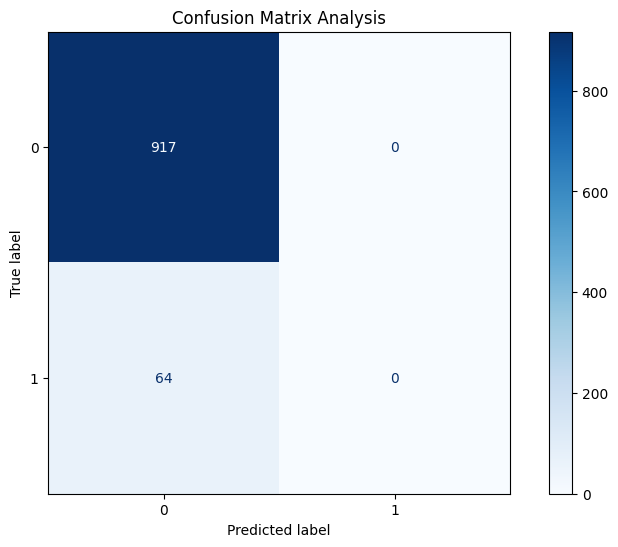



RANDOM FOREST READY DATASET:
     id   age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
2    91  42.0             0              0              98.53  18.5       0   
11  242   4.0             0              0              98.56  17.5       0   
25  479  59.0             1              0              78.28  31.0       0   
27  507  28.0             0              0              94.15  23.1       0   
28  530  12.0             0              0              75.22  20.9       0   

    pred classification_type  gender_code  ever_married_code  work_type_code  \
2    0.0       True Negative            0                  0               2   
11   0.0       True Negative            1                  0               4   
25   0.0       True Negative            0                  1               2   
27   0.0       True Negative            0                  1               2   
28   0.0       True Negative            0                  0               4   

    Residence

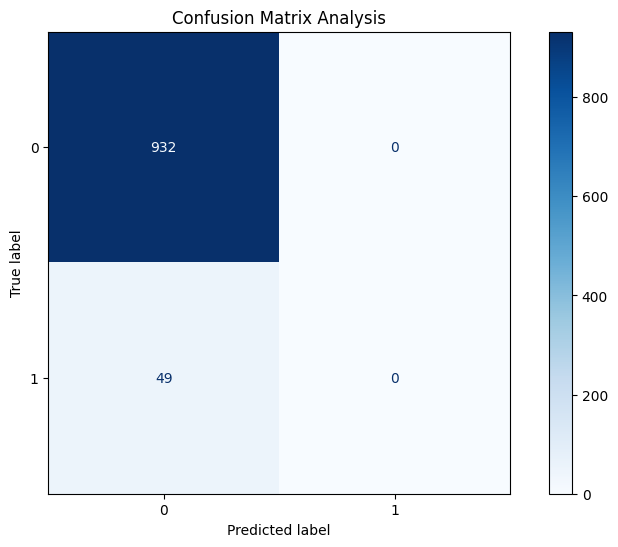



RANDOM FOREST READY DATASET:
     id   age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
12  247  31.0             0              0              72.60  31.6       0   
16  338  43.0             0              0             110.32  28.4       0   
17  354  65.0             0              0              72.49  28.9       0   
42  727  44.0             0              0              95.46  31.4       0   
43  728   8.0             0              0              88.83  18.5       0   

    pred classification_type  gender_code  ever_married_code  work_type_code  \
12   0.0       True Negative            1                  0               2   
16   0.0       True Negative            0                  1               2   
17   0.0       True Negative            0                  1               2   
42   0.0       True Negative            1                  1               2   
43   0.0       True Negative            1                  0               4   

    Residence

In [3]:
import mlflow
from typing import Literal
from DataProcesser.utils import final_analysis

# Saves directly to env output dir
output_dir = PATH_OUTPUT_DIR
if os.environ["AMBIENTE"] == "KAGGLE":
    output_dir = PATH_DATASET.parent

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"sqlite:///{PATH_CODE}/mlflow.db")
ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
models: list[ARQ_TYPE] = ["MLP", "KAN"]
# os.environ["OPTUNA"] = "True"

SORT_METRIC = "val_f_beta_avg"
RESIDUAL = True
unwanted_metrics = ["epoch", "step"]
compare_df, resProcesser = final_analysis(
    models, output_dir, SORT_METRIC, unwanted_metrics, residual=RESIDUAL
)

compare_df.to_csv(output_dir / "classify_results.csv")
print(compare_df.to_string())

ser_fbeta = compare_df[SORT_METRIC].sort_values(ascending=False)
best_model, fbeta_value = next(ser_fbeta.items())
print(f"BEST MODEL: *{best_model}* WITH F-BETA: {fbeta_value}\n")

# If true, execute residual analysis of best model's errors
if RESIDUAL and False:
    resProcesser.fit_predict(str(best_model))
    pass


## Clear previous trainings

In [ ]:
import shutil
import os
import gc

# Define paths to MLflow storage
db_path = PATH_CODE / "mlflow.db"
mlruns_path = PATH_CODE / "mlruns"
artifacts_dir = PATH_OUTPUT_DIR / "artifacts"

# Remove MLflow database file
if db_path.exists():
    os.remove(db_path)
    print(f"Deleted database: {db_path}")

# Remove MLflow artifacts directory
if mlruns_path.exists():
    shutil.rmtree(mlruns_path)
    print(f"Deleted artifacts folder: {mlruns_path}")

# Remove custom artifacts directory (CSVs generated during training)
if artifacts_dir.exists():
    shutil.rmtree(artifacts_dir)
    print(f"Deleted custom artifacts: {artifacts_dir}")

gc.collect()

## MLFlow's Dashboard (Only works outside of Kaggle)
### Download the training results from Kaggle and paste them into a cloned folder of the repository

In [ ]:
import shutil
import subprocess
from pathlib import Path
import pathlib


def see_model(database: pathlib.Path, folder: pathlib.Path):
    subprocess.Popen(
        [
            "mlflow",
            "ui",
            "--backend-store-uri",
            f"sqlite:///{database}",
            "--default-artifact-root",
            folder,
            "--host",
            "127.0.0.1",
            "--port",
            "5000",
        ]
    )


if __name__ == "__main__":
    PATH_RES_ZIPADO = Path(
        "C:\\Users\\LUIS_FELIPE\\Downloads\\resultado_kaggle_stroke_1.zip"
    )
    DIR = Path(Path.cwd(), PATH_RES_ZIPADO.name.replace(".zip", ""))
    print(f"DIR: {DIR}")
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir()
    shutil.unpack_archive(PATH_RES_ZIPADO, DIR)

    print("COMECANDO SUBPROCESSO!\n")
    see_model(DIR / "mlflow.db", DIR / "mlruns")
